In [3]:
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import optimizers, regularizers, losses
from tensorflow.keras.layers import Dense, Dropout
from hyperopt import fmin, tpe, hp, Trials, rand

from sklearn.calibration import calibration_curve

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # should shut TF up a bit

sns.set()
np.set_printoptions(threshold=256)
rc = {"font.family": "serif",
      "mathtext.fontset": "stix",
      "figure.dpi": 100,
      "figure.figsize": [9, 5],
      "font.serif": ["Charter"] + plt.rcParams["font.serif"]
      }
plt.rcParams.update(rc)

COLAB = 'google.colab' in str(get_ipython())
# if COLAB:
#     from google.colab import drive
#     drive.mount('/content/drive/',)
#     %cd /content/drive/MyDrive/Thesis/

### Somewhat finalized functions

(Not using seperate files bc Colab doesn't like it.)

In [10]:
### SIMULATING

def visualize(X, Y_prob, fX=False):
    print("X:\n", X.round(3))
    print("Normalized funcs(X) = Y probabilities:")
    print(Y_prob.round(3))
    if type(fX) != bool:
        print("Unnormalized funcs(X):")
        print(fX.round(3))
        print("Euclidean distance between those:", np.linalg.norm(fX - Y_prob))

    t_space = np.geomspace(1e-20, 1, 10_000)  # denser where small.
    p_X_smaller = [np.mean(Y_prob <= t) for t in t_space]

    if X.ndim > 2:
        print("X dimensionality too high to visualize.")
        return -1

    plt.figure()
    plt.xlabel("$x$")
    plt.ylim(0, 1.05)

    if X.ndim == 1:
        plt.plot(t_space, p_X_smaller, color='red',
                 label='$\mathrm{\mathbb{P}}(\mathbf{p}(X) \leq x)$')
        x, _, p = plt.hist(X, bins=30, density=True, alpha=.3,
                           label='Scaled density of $X$')
        # Histogram scaling:
        for item in p:
            item.set_height(item.get_height() / max(x))

        # Empirical function plotting:
        order = np.argsort(X)
        for i in range(Y_prob.shape[1]):
            plt.plot(X[order], Y_prob[order, i], label=f'$p^0_{i+1}(x)$')

        plt.legend()
        # plt.savefig('situ11.pdf')
        plt.show()


def normalize(fX):
    # fX's shape is n x len(funcs).
    return np.array([fX[i] / x_sum for i, x_sum in enumerate(fX.sum(axis=1))])


def probs(X, funcs, viz=False):
    fX = np.array([f(X) for f in funcs]).T
    Y_prob = normalize(fX)
    if viz:
        visualize(X, Y_prob, fX)
    return Y_prob


def sample_and_funcs(situation, n=10_000, viz=False, seed=42):
    np.random.seed(seed)
    extras = {}
    if situation == "1":
        desc = f"Situation 1: sampling {n} X_i ~ 1D uniform. f1(X) = (1 + X) / 3. K = 2."
        X = np.random.uniform(size=n)
        # def f1(X): return X
        # def f2(X): return 1-f1(X)
        def f1(X): return (1 + X) / 3
        def f2(X): return (2 - X) / 3
        funcs = [f1, f2]
    elif "5" in situation:
        r_str = situation.split('.')[1]
        if r_str.isdigit():
            r = int(r_str)
        else:
            r = 5
            print("r not specified, just setting it to 5.")
        desc = f"Situation 5: sampling {n} X_i ~ 1D uniform. f1(X) = X^{r}. K = 2. α = 1 / {r}."
        X = np.random.uniform(size=n)
        def f1(X): return X ** r
        def f2(X): return 1 - f1(X)
        funcs = [f1, f2]
    elif "10" in situation:
        r_str = situation.split('.')[1]
        if r_str.isdigit():
            r = int(r_str)
        else:
            r = 5
            print("r not specified, just setting it to 5.")
        b = .1
        br = b ** r
        desc = f"Situation 10: sampling {n} X_i ~ 1D uniform. f1(X) = X^{r} up to {b}. K = 2."
        X = np.random.uniform(size=n)

        def f1(X): return np.array([br + X_i - b if X_i > b else X_i ** r for X_i in X])

        def f2(X): return br + 1 - b - f1(X)
        funcs = [f1, f2]
        
        # I may store more info like this
        if n == 4096:
            extras.update({'L': 2, 'lr': 0.004042471964784935})

    else:
        raise ValueError("Situation not implemented.")

    if viz:
        print(desc)
    extras['Description'] = desc
    return X, funcs, extras


def create_dataset(situation, n=10_000, viz=False, seed=42):
    X, funcs, extras = sample_and_funcs(situation, n, viz, seed)
    return X, funcs, probs(X, funcs, viz), extras


# TRAINING


def keras_prep(X, Y_prob):
    if X.ndim == 1:
        X = X.reshape(-1, 1)  # make fake 2-dimensional

    _, k = Y_prob.shape
    # Assign sample to category with a categorical probability.
    Y_cat = np.array([np.random.choice(k, 1, p=p) for p in Y_prob])
    Y_one_hot = np.eye(k)[Y_cat.reshape(-1,)]  # now a one-hot matrix
    return X, Y_one_hot


def keras_classifier(hidden_widths, X_train, Y_train, drop=.2, l1=.001):
    # ReLU activations for hidden layer, softmax for final.
    # Force _some_ sparsity through dropout and penalizing weights with L1.
    # Note: not the same as theory yet, that has normalization and probably
    #       requires some special strategies for _real_ sparsity.

    m = [X_train[0].shape, *hidden_widths, Y_train[0].size]
    L = len(hidden_widths)
    model = tf.keras.models.Sequential(name=f'L-is-{L}-and-p_0-is-{m[0][0]}')

    model.add(Dense(m[1], input_shape=m[0], name=f'p_0->p_1',
                    kernel_regularizer=regularizers.l1(l1)))
    for i in range(2, len(m) - 1):
        model.add(Dropout(drop))
        model.add(Dense(m[i], activation='relu', name=f'p_{i-1}->p_{i}',
                        kernel_regularizer=regularizers.l1(l1)))

    model.add(Dropout(drop))
    model.add(Dense(m[-1], activation='softmax', name=f'p_{L}->p_{L+1}',
                    kernel_regularizer=regularizers.l1(l1)))
    return model


def train_network(X, Y_prob, X_val, Y_prob_val, hw=[16, 16, 16, 16], viz=0, 
                  loss_fn='categorical_crossentropy', opt='adam', stop=.0002, drop=.2, l1=.001):
    X_keras, Y_one_hot = keras_prep(X, Y_prob)
    X_val_keras, Y_val_one_hot = keras_prep(X_val, Y_prob_val)

    model = keras_classifier(hw, X_keras, Y_one_hot, drop, l1)

    if viz > 1:
        print(model.summary())

    model.compile(opt, loss_fn, metrics=['accuracy'])
    cb = [tf.keras.callbacks.EarlyStopping('loss', min_delta=stop, patience=12, 
                                           verbose=0, restore_best_weights=True)]
    history = model.fit(X, Y_one_hot, epochs=420, validation_data=(X_val_keras, Y_val_one_hot), 
                        callbacks=cb, batch_size=4, use_multiprocessing=True, verbose=viz)

    if viz > 0:
        pd.DataFrame(history.history).plot()
        plt.gca().set_ylim(
            0, max(1, np.quantile(history.history['val_loss'], .98)))
        # ^ Dynamic to make it compatible with different loss functions.
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.show()

    return model


# EVALUATING


def visualize_tf(model, X_test, Y_prob_test):
    Y_test_pred = model.predict(X_test)  # probabilities ofc.

    if X_test.ndim == 1:
        order = np.argsort(X_test)
        for i in range(Y_prob_test.shape[1]):
            plt.plot(X_test[order], Y_test_pred[order, i],
                     label=f'$\hat{{p}}_{i+1}(x)$')
            plt.plot(X_test[order], Y_prob_test[order, i], '--', label=f'$p^0_{i+1}(x)$',
                     color=plt.gca().lines[-1].get_color())
        plt.xlabel('x')
        plt.legend()
        plt.show()


def ll_loss(true, pred):
    return tf.keras.losses.categorical_crossentropy(true, pred).numpy().mean()


def KL_loss(true, pred):
    return tf.keras.losses.KLDivergence()(true, pred).numpy().mean()


def KL_trunc_loss(true, pred, B, minimum=1e-5):
    # Ugly and slow to make it transparent, bc I'm not sure.
    divergences = []
    for i, true_vec_i in enumerate(true):
        pred_vec_i = pred[i]
        current_sum = 0
        for k, true_i_k in enumerate(true_vec_i):
            pred_i_k = pred_vec_i[k]
            if pred_i_k < minimum:
                current_sum += true_i_k * B
            else:
                current_sum += true_i_k * \
                    np.minimum(B, np.log(true_i_k / pred_i_k))
        divergences.append(current_sum)
    return np.mean(divergences)


def MSE(true, pred):
    return tf.keras.losses.MeanSquaredError()(true, pred).numpy()


def test_loss(model, X_test, Y_prob_test, B=1.5, Y_test_pred=None):
    if Y_test_pred is None:
        Y_test_pred = model.predict(X_test)
    return {
        "LL ": ll_loss(Y_prob_test, Y_test_pred),
        "MSE": MSE(Y_prob_test, Y_test_pred),
        "KL ": KL_loss(Y_prob_test, Y_test_pred),
        f"KL_B={B}": KL_trunc_loss(Y_prob_test, Y_test_pred, B)
    }


def get_sparsity(model, epsilon=0.001):
    W = model.get_weights()
    nz_biases = biases = nz_weights = weights = 0
    for i, W_i in enumerate(W):
        if i % 2 == 0:
            nz_weights += np.count_nonzero(W_i > epsilon)
            weights += W_i.size
        else:
            nz_biases += np.count_nonzero(W_i > epsilon)
            biases += W_i.size
    return {
        "Biases > e. ": nz_biases, "Total biases": biases,
        "Weights > e.": nz_weights, "Tot. weights": weights,
        "Epsilon     ": epsilon, "s           ": nz_biases + nz_weights
    }


def sup_prob_diff(probs1, probs2):
    return np.amax(np.abs(probs1 - probs2))


def get_all_quantities_of_interest(model, X_test, Y_prob_test):
    Y_test_pred = model.predict(X_test)
    return {
        **test_loss(model, X_test, Y_prob_test, Y_test_pred=Y_test_pred),
        **get_sparsity(model),
        "Pr. max difference": sup_prob_diff(Y_prob_test, Y_test_pred)
    }

### Interactive stuff

Situation 5: sampling 4096 X_i ~ 1D uniform. f1(X) = X^2. K = 2. α = 1 / 2.
X:
 [0.375 0.951 0.732 ... 0.929 0.332 0.465]
Normalized funcs(X) = Y probabilities:
[[0.14  0.86 ]
 [0.904 0.096]
 [0.536 0.464]
 ...
 [0.863 0.137]
 [0.11  0.89 ]
 [0.217 0.783]]
Unnormalized funcs(X):
[[0.14  0.86 ]
 [0.904 0.096]
 [0.536 0.464]
 ...
 [0.863 0.137]
 [0.11  0.89 ]
 [0.217 0.783]]
Euclidean distance between those: 0.0


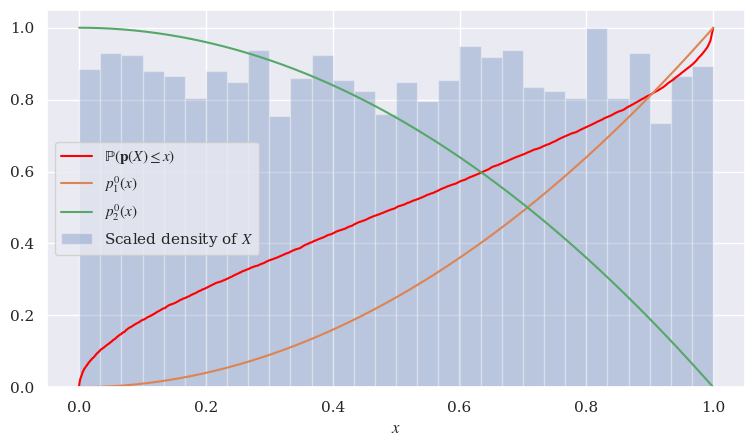

In [11]:
situation = str(5.2)
n = 4096

X, funcs, Y_prob, extras = create_dataset(situation, n=n, viz=True)
X_val, _, Y_prob_val, _ = create_dataset(situation, n=10^4, viz=False)
X_test, _, Y_prob_test, _ = create_dataset(situation, n=10^6, viz=False)


**Iteration 1 of training a [16, 16, 16, 16] network on 4096 samples in situation 10**


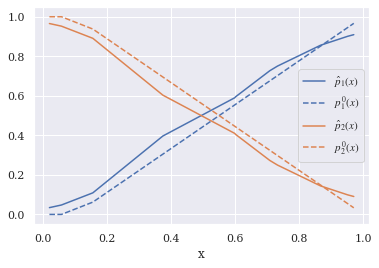

(Test set) quantities of interest:
LL  0.3881986
MSE 0.0024361524
KL  0.015403527
KL_B=1.5 0.0154036347818209

**Iteration 2 of training a [16, 16, 16, 16] network on 4096 samples in situation 10**


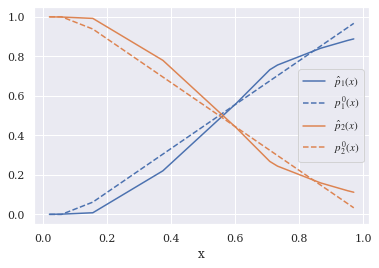

(Test set) quantities of interest:
LL  0.39343813
MSE 0.0024612667
KL  0.0206431
KL_B=1.5 0.015429871473967854

**Iteration 3 of training a [16, 16, 16, 16] network on 4096 samples in situation 10**


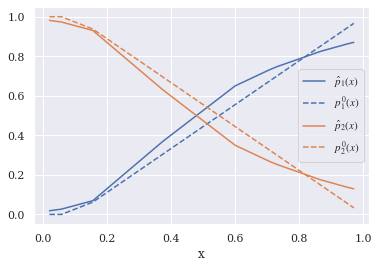

(Test set) quantities of interest:
LL  0.3895717
MSE 0.0037723836
KL  0.016776571
KL_B=1.5 0.016776672341494697


In [4]:
for i in range(3):
    hw = [16 for _ in range(4)]
    opt = optimizers.Adam(.002)
    print(f"\n**Iteration {i + 1} of training a {hw} network on {n} samples in situation {situation}**")
    model = train_network(X, Y_prob, X_val, Y_prob_val, viz=0, hw=hw, opt=opt)
    visualize_tf(model, X_test, Y_prob_test)
    print("(Test set) quantities of interest:")
    [print(k, v) for k, v in test_loss(model, X_test, Y_prob_test).items()]

#### In progress

In [12]:
def opt_network(situation, n, viz=1, max_evals=42):
    # Parameters we definitely want: widths, learning rate
    # Probably: L1 penalty, dropout rate, number of layers, more Adam settings
    # TODO: make some parameters depend on n

    def obj(params):
        hw = [16 for _ in range(params['L'])]
        opt = optimizers.Adam(params['lr'])

        X, _, Y_prob, _ = create_dataset(situation, n, seed=np.random.randint(1000))
        X_val, _, Y_prob_val, _ = create_dataset(situation, 10^4, seed=np.random.randint(1000))
        # To avoid dimension issues give it one validation sample.
        model = train_network(X, Y_prob, X_val, Y_prob_val, hw=hw, opt=opt, stop=.0005)

        pred = model.predict(X_val)
        kl = KL_loss(Y_prob_val, pred)
        if viz > 0:
            mse = MSE(Y_prob_val, pred)
            print(f"KL {kl:.4f} and MSE {mse:.4f} with parameters {params}")
        return kl

    param_space = {}
    param_space['L-2'] = 2 + hp.randint('Number of layers - 2', 4)
    param_space['lr'] = hp.uniform('Adam learning rate', 0.001, 0.008)
    print(f"Searching for optimal {param_space.keys()} in {max_evals} attempts.")
    print(f"We're in situation {situation} with {n} samples.")
    
    tpe_best = fmin(fn=obj, space=param_space, algo=tpe.suggest, max_evals=max_evals)
    return tpe_best

In [13]:
opt_network(str(5.2), 512) # .0546, 0.0206

Searching for optimal dict_keys(['L', 'lr']) with 42 attempts.
We're in situation 5.2 with 512 samples.
KL 0.0266 and MSE 0.0073 with parameters {'L': 4, 'lr': 0.006003927718752042}
KL 0.0043 and MSE 0.0014 with parameters {'L': 3, 'lr': 0.0023206419887298498}
KL 0.0338 and MSE 0.0127 with parameters {'L': 2, 'lr': 0.006742566877142479}
KL 0.0087 and MSE 0.0018 with parameters {'L': 3, 'lr': 0.004229551416046064}
 10%|▉         | 4/42 [00:35<05:45,  9.10s/it, best loss: 0.0042724609375]WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f7ec5e3f840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that re

{'Adam learning rate': 0.0034302391425215404, 'Number of layers - 2': 0}

In [15]:
opt_network(str(5.2), 4096) # 0.0027, 0.0004

Searching for optimal dict_keys(['L', 'lr']) with 42 attempts.
We're in situation 5.2 with 4096 samples.
  0%|          | 0/42 [00:00<?, ?it/s, best loss: ?]WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f7ec466c8c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
KL 0.0318 and MSE 0.0077 with parameters {'L': 3, 'lr': 0.0010601400757207283}
  2%|▏         | 1/42 [00:

{'Adam learning rate': 0.003918518230041258, 'Number of layers - 2': 0}

In [16]:
opt_network(str(5.2), 12800) # 0.0024, 0.0003

Searching for optimal dict_keys(['L', 'lr']) with 42 attempts.
We're in situation 5.2 with 12800 samples.
  0%|          | 0/42 [00:00<?, ?it/s, best loss: ?]WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f7ebd5a9d08> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
KL 0.0152 and MSE 0.0042 with parameters {'L': 2, 'lr': 0.004380860497896271}
  2%|▏         | 1/42 [01:

{'Adam learning rate': 0.005502676381140165, 'Number of layers - 2': 1}

### Temporarily moved out of the way

In [6]:
def unif_rejection_sampling(p, n=10_000, seed=1):
    # Rejection sampling from p; proposal is unif[0, 1].
    # MAYDO: faster sampling method.
    np.random.seed(seed)
    q_pdf = ss.uniform().pdf
    q_sample = np.random.uniform

    grid = np.linspace(0, 1, 1000)
    m = max(p(grid)) * 1.3  # should divide by q_pdf(grid) but that's always 1.
    # The 1.3 factor is just to be sure m * q > p. Proportion accepted ~ 1/m.

    X = []
    while len(X) < n:
        z = q_sample()
        if np.random.uniform(0, m * q_pdf(z)) <= p(z):
            X.append(z)
    return np.array(X)


In sample_and_funcs:
    elif situation == "2":
        desc = f"Situation 2: sampling {n} X_i ~ 2D uniforms. f1(X) = sum(X) / 2. K = 2."
        X1 = np.random.uniform(size=n)
        X2 = np.random.uniform(size=n)
        X = np.column_stack([X1, X2])
        def f1(X): return (X[:, 0] + X[:, 1]) / 2
        def f2(X): return 1 - f1(X)
        funcs = [f1, f2]
    elif situation == "3":
        desc = f"Situation 3: sampling {n} X_i ~ a mixture of normals. K = 2."
        mu = [.4, .8]
        sigma = [.5, .1]
        pY = [.5, .5]

        def p(x):
            return sum([ss.norm(mu[i], sigma[i]).pdf(x) * pY[i] for i in range(len(mu))])

        X = unif_rejection_sampling(p, n, seed)
        funcs = [ss.norm(mu[i], sigma[i]).pdf for i in range(len(mu))]
    elif situation == "4":
        desc = f"Situation 4: sampling {n} X_i ~ 1D uniform. f1(X)=f2(X). K = 2."
        X = np.random.uniform(size=n)
        def f1(X): return (1 + X) / 3
        def f2(X): return f1(X)
        funcs = [f1, f2]
        elif "6." in situation:
        # TODO: handle above?
        K_str = situation.split('.')[1]
        if K_str != "":
            K = int(K_str)
        else:
            K = 3
            print("K not specified, just setting it to 3.")
        desc = f"Situation 6: sampling {n} X_i ~ 1D uniform. f_k(X) = a normal. K = {K}."
        X = np.random.uniform(size=n)
        funcs = []
        for k in range(K):
            funcs.append(lambda x, k=k: ss.norm(k / K, 0.5 / K).pdf(x))
    elif situation == "7":
        desc = f"Situation 7: sampling {n} X_i ~ 1D uniform. f1(X) = TODO. K = 2."
        X = np.random.uniform(size=n)
        beta = 4
        def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * beta))
        def f2(X): return 1 - f1(X)
        funcs = [f1, f2]
    elif situation == "8":
        desc = f"Situation 8: sampling {n} X_i ~ a mixture of uniforms. K = 2."
        a = [0.05, .55]
        b = [.45, .95]
        pY = [.5, .5]

        def p(x):
            return sum([ss.uniform(a[i], b[i]).pdf(x) * pY[i] for i in range(len(pY))])

        X = unif_rejection_sampling(p, n, seed)
        def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * 3))
        def f2(X): return 1 - f1(X)
        funcs = [f1, f2]
    elif situation == "9":
        desc = "Taylor sin(uniform[0, pi / 2])."
        X = np.random.uniform(high=np.math.pi/2, size=n)
        m = 10  # can't be high, factorial gets too large
        def f1(X): return 1e-10 + sum(
            [(-1) ** (i+1) * X ** (2*i-1) / np.math.factorial(2*i-1) for i in range(1, m)])

        def f2(X): return 1 - f1(X)
        funcs = [f1, f2]

In visualize:
    elif X.ndim == 2:
        plt.plot(t_space, p_X_smaller, color='red',
                 label='$\mathrm{\mathbb{P}}(\mathbf{p}(\mathbf{X}) \leq x)$')
        x, _, p = plt.hist(X, bins=30, density=True, alpha=.3,
                           label=[f'Scaled density of $X_{j+1}$' for j in range(X.shape[1])])
        for j in range(X.ndim):
            for item in p[j]:
                item.set_height(item.get_height() / max(x[j]))

        plt.legend()
        plt.show()

        # Subset in case 2D:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        subset = np.random.choice(X.shape[0], 200)
        for i in range(Y_prob.shape[1]):
            ax.scatter(X[subset, 0], X[subset, 1], Y_prob[subset, i],
                       label=f'$p^0_{i+1}(\mathbf{{x}})$')
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.legend()
        plt.show()
        plt.show()

In visualize_tf:
    elif X_test.shape[1] == 2:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        n, k = Y_prob_test.shape
        subset = np.random.choice(n, 200)
        step = int(n / 200)
        subset = list(np.argsort(X_test[:, 0]))[::step]
        # MAYDO: seperate plots for both classes
        for i in range(k):
            ax.scatter(X_test[subset, 0], X_test[subset, 1], Y_test_pred[subset, i],
                       label=f'$\hat{{p}}_{i+1}(\mathbf{{x}})$')
            ax.scatter(X_test[subset, 0], X_test[subset, 1], Y_prob_test[subset, i],
                       label=f'$p^0_{i+1}(\mathbf{{x}})$', marker='^')

        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.legend()
        plt.show()
        plt.show()
    else:
        print("Not visualizing since X.ndim > 2")

SyntaxError: ignored